# 1. Подготовка данных

In [1]:
from oandapyV20 import API
from oandapyV20.endpoints.instruments import InstrumentsCandles
from oandapyV20.endpoints.accounts import AccountInstruments

from abc import ABCMeta, abstractmethod, abstractproperty
from configparser import ConfigParser

from datetime import datetime
from operator import itemgetter

class Api:
    def __init__(self, broker):
        _access_token, _account_id = self._acc_info(broker_name='Oanda')

        broker.connect(access_token=_access_token, account_id=_account_id)
        self._broker = broker
    
    def _acc_info(self, broker_name):
        config = ConfigParser()
        config.read('token.init')

        broker_info = config[broker_name]
        return broker_info['access_token'], broker_info['account_id']

    def available(self, type_info=['name', 'type']):
        return self._broker.available(type_info=type_info)

    def iter_price(self,
                since,
                to=None,
                instrument='EUR_USD',
                ohlc='o',
                granularity='D',
                volume=False,
                abm='A'):
        '''
        Parse data with instrument candles.
        Args:
            since: the start of the time range to fetch candlesticks for.
            to: the end of the time range to fetch candlesticks for.
            ohlc: list of types(open, high, low, close) prices
            abm: ask, bid, mid
        Returns:
            generator object with datetime and open ask daily price by default.
        '''

        return self._broker.iter_price(since, to, instrument, ohlc, granularity, volume, abm)

class Broker(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        pass

    @abstractmethod
    def iter_price(self):
        pass

In [2]:
class Oanda(Broker):
    def connect(self, access_token, account_id):
        self.client = API(access_token=access_token)
        self.account_id = account_id

    def available(self, type_info):
        endpoint = AccountInstruments(accountID=self.account_id)
        rows = self.client.request(endpoint)

        for row in rows['instruments']:
            yield itemgetter(*type_info)(row) 
    
    def iter_price(self, since, to, instrument, ohlc, granularity, volume, abm):

        dt_format = '%Y-%m-%d %H:%M:%S'
        rfc3339 = '%Y-%m-%dT%H:%M:%S.%f000Z'

        iso_since = datetime.strptime(since, dt_format).isoformat()
        iso_to = None
        
        if to:
            iso_to = datetime.strptime(to, dt_format).isoformat()

        params = {
            'from': iso_since,
            'to': iso_to,
            'granularity': granularity,
            'price': abm,
            'count': 5000
            }
        
        components = {
                'A': 'ask',
                'B': 'bid',
                'M': 'mid'
                }

        entrypoint = InstrumentsCandles(instrument=instrument, params=params)
        rows = self.client.request(entrypoint)
        instrument = rows['instrument']

        for row in rows['candles']:
            dt = datetime.strptime(row['time'], rfc3339)

            abm_values = row[components[abm]]
            price = itemgetter(*ohlc)(abm_values)
            
            if volume:
                yield dt, price, row['volume']
            else:
                yield dt, instrument, float(price)

Используем api Oanda для выборки цен закрытия по паре евро-доллар начиная с 2015-07-01 00:00:00 и гранулярностью H1

In [3]:
oanda = Api(Oanda())
prices = oanda.iter_price('2015-07-01 00:00:00', granularity='H1', instrument='EUR_USD', ohlc='c')

In [4]:
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py

In [5]:
eur_usd = pd.DataFrame([i for i in prices], columns=['datetime', 'inst', 'close'])
eur_usd.index = eur_usd['datetime']

In [6]:
eur_usd.head(10)

,datetime,inst,close
datetime,,,
2015-07-01 04:00:00,2015-07-01 04:00:00,EUR_USD,1.11399
2015-07-01 05:00:00,2015-07-01 05:00:00,EUR_USD,1.11301
2015-07-01 06:00:00,2015-07-01 06:00:00,EUR_USD,1.11262
2015-07-01 07:00:00,2015-07-01 07:00:00,EUR_USD,1.11143
2015-07-01 08:00:00,2015-07-01 08:00:00,EUR_USD,1.11497
2015-07-01 09:00:00,2015-07-01 09:00:00,EUR_USD,1.11252
2015-07-01 10:00:00,2015-07-01 10:00:00,EUR_USD,1.11115
2015-07-01 11:00:00,2015-07-01 11:00:00,EUR_USD,1.11044
2015-07-01 12:00:00,2015-07-01 12:00:00,EUR_USD,1.10972


In [106]:
def plot_inst(frame, test=None):

    trace1 = go.Scatter(
        x=frame.index,
        y=frame['close'],
        name='EUR/USD',
        line = dict(
            color = ('rgb(205, 12, 24)'),
            width = 1,)
        )

    data = [trace1]

    layout = dict(title = 'Цены закрытия по паре EUR/USD',
                   xaxis=dict(
                        showline=True,
                        showgrid=False,
                        showticklabels=True,
                        linecolor='rgb(204, 204, 204)',
                        linewidth=2,
                        ticks='outside',
                        tickcolor='rgb(204, 204, 204)',
                        tickwidth=2,
                        ticklen=5,
                        tickfont=dict(
                            family='Arial',
                            size=12,
                            color='rgb(82, 82, 82)',
                        ),
                    ),
                  yaxis = dict(title = 'Цена'),
                  plot_bgcolor='rgba(0,0,0,0)',

                  annotations=[dict(xref='paper', yref='paper', x=0.5, y=-0.1,
                                  xanchor='left', yanchor='top',
                                  text='Oanda',
                                  font=dict(family='Arial',
                                            size=25,
                                            color='rgb(150,150,150)'),
                                  showarrow=False)]
                  )
    
    if test is not None:
        trace2 = go.Scatter(
            x=test.index,
            y=test['close'],
            name='test',
            line = dict(
                color = ('rgb(100, 100, 100)'),
                width = 1,)
            )
        
        
        data.append(trace2)

    fig = dict(data=data, layout=layout)
    py.iplot(fig)

In [108]:
plot_inst(eur_usd)

# Метод локальной аппроксимации

Наиболее важный результат пере
хода от глобальной аппроксимации
к
локальной при прогнозировании достаточно длинных
хаотических временных рядов состоит в том, что длина прогноза ограничивается в первую
очередь не возможностями метода (как при глобальной аппроксимации), а
лишь особенностями динамики ряда.

# 2. Вложение методом временной задержки

Теорема Такенса

In [110]:
import numpy as np

def delays(row, tau, m):
    """
    m is embedding dimension
    tau is delay
    
    """
    size = row.size
    space = np.ndarray([m, size-(m-1)*tau])
    
    for i in range(m):
        space[i, :] = row[i*tau:size+(i-m+1)*tau]
    
    return space

In [81]:
test.index[0].strftime('%Y-%m-%d %H-%M-%S')

'2016-02-23 03-00-00'

In [88]:
[test.index[0].strftime('%Y-%m-%d'), test.index[0].strftime('%Y-%m-%d')]

['2016-02-23', '2016-02-23']

In [107]:
smoothed = eur_usd['close'].rolling(5).mean()

train, test = pd.DataFrame(smoothed)[:4000], pd.DataFrame(smoothed)[4001:]
plot_inst(train, test)

В качестве примера выберем размерность вложения и задержку: m = 3, tau = 150.
Существуют алгоритмы для выбора этих параметров, но можно пойти эмпирическим путем.
На модельных задачах было замечено, что хорошая реконструкция не должна вытягиваться вдоль главной диагонали.

In [123]:
phase_space = delays(train.values.reshape(1, -1)[0], 200, 3)

In [125]:
trace1 = go.Scatter3d(
    x=phase_space[0],
    y=phase_space[1],
    z=phase_space[2],
    mode='markers',
    marker=dict(
        size=2,
        line=dict(
            color='rgba(255, 255, 255, 200)',
            width=0.3
        )
    )
)

data = [trace1]

layout = dict(title = 'Фазовая траектория по EUR/USD',
              yaxis = dict(title = 'Цена'),
              plot_bgcolor='rgba(100,0,0,0)',
              )


fig = dict(data=data, layout=layout)
py.iplot(fig)

# 3. Выбор соседей



In [546]:
def nearest_trajectories(phase_space, neighbours, future=False):
    splited = []
    start = 0

    for i in range(len(neighbours)-1):
    
        if neighbours[i+1] - neighbours[i] > 1:
            if future:
                yield phase_space[neighbours[start:i]], phase_space[neighbours[i]:neighbours[i]+10]
            
            start = i + 1

In [500]:
from sklearn.neighbors import KDTree

phase_space_t = phase_space.T

train, test = phase_space_t[:4000], phase_space_t[4001:]
start_point = train[-1]

tree = KDTree(train, leaf_size=30)
indices = tree.query_radius([start_point], r=0.03)

In [547]:
indices[0].sort()
traj = [i for i in nearest_trajectories(train, indices[0], future=True)]

In [551]:
traj[0][1]

array([[1.097764, 1.102118, 1.135002],
       [1.097414, 1.103622, 1.136096],
       [1.097298, 1.10432 , 1.136762],
       [1.097406, 1.104842, 1.137064],
       [1.09732 , 1.105278, 1.137708],
       [1.09708 , 1.105398, 1.13811 ],
       [1.097028, 1.104936, 1.138492],
       [1.09701 , 1.104096, 1.139244],
       [1.09679 , 1.103402, 1.141178],
       [1.096576, 1.103378, 1.142452]])

In [ ]:
np.concatenate((traj[0][0], traj[0][1])

In [561]:
frame = pd.DataFrame(np.concatenate((traj[0][0], traj[0][1])), columns=['x', 'y', 'z'])

In [562]:
frame

,x,y,z
0,1.113204,1.103294,1.098642
1,1.112910,1.102212,1.098574
2,1.112538,1.101084,1.098350
3,1.112102,1.100882,1.098124
4,1.111760,1.100546,1.097792
...,...,...,...
503,1.097080,1.105398,1.138110
504,1.097028,1.104936,1.138492
505,1.097010,1.104096,1.139244
506,1.096790,1.103402,1.141178


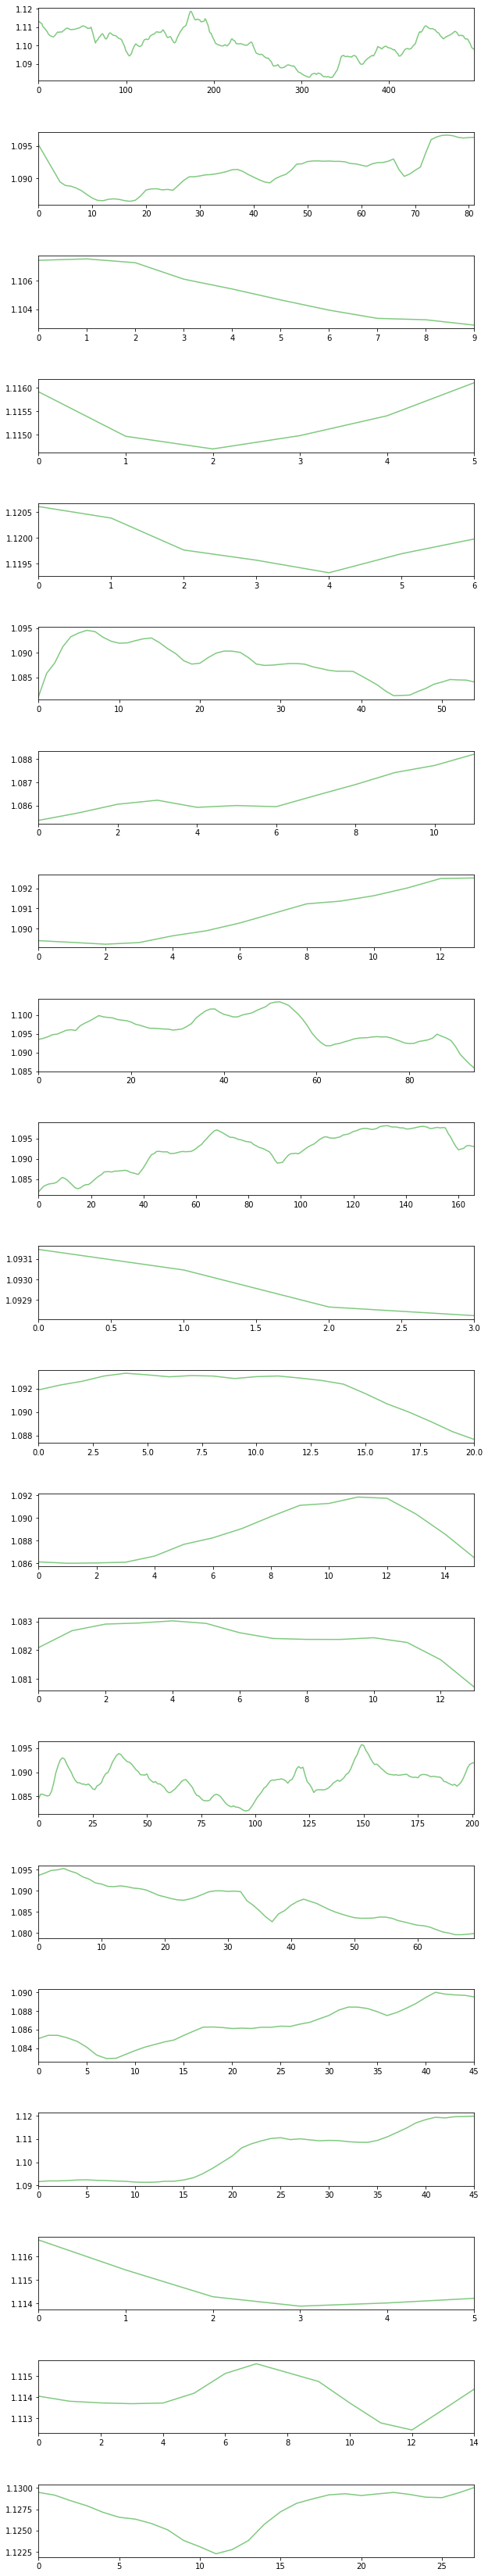

In [530]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(len(traj),1, figsize=(10, 60))
plt.subplots_adjust(wspace=0.2, hspace=0.7)

for i in range(len(traj)):
    pd.DataFrame(traj[i], columns=['x', 'y', 'z'])['x'].plot(ax=axes[i], colormap='Accent')

# 4. Аппроксимация